# Two Way Fixed Effects
- Powerful tool to eliminate any confounding that is fixed for units and time periods.
- Can be applied to block adoption (one-shot) and staggered adoption settings.
- Can be extended, in block adoption setting, to capture time-varying treatment effects ('sluggish impact'), through event study design
- However, when we have staggered adoption + sluggish adoption, the group that started lat 

### Block Treatments

,i,t,Y_it,post_t,treated_i,D_it
0,1,2023-01-01,90.756099,0,1,0
1,1,2023-01-02,99.808678,0,1,0
2,1,2023-01-03,115.965915,0,1,0
3,1,2023-01-04,123.739068,0,1,0
4,1,2023-01-05,107.337489,0,1,0
...,...,...,...,...,...,...
5105,14,2023-12-27,679.632183,1,0,0
5106,14,2023-12-28,665.858395,1,0,0
5107,14,2023-12-29,658.722140,1,0,0
5108,14,2023-12-30,645.507638,1,0,0


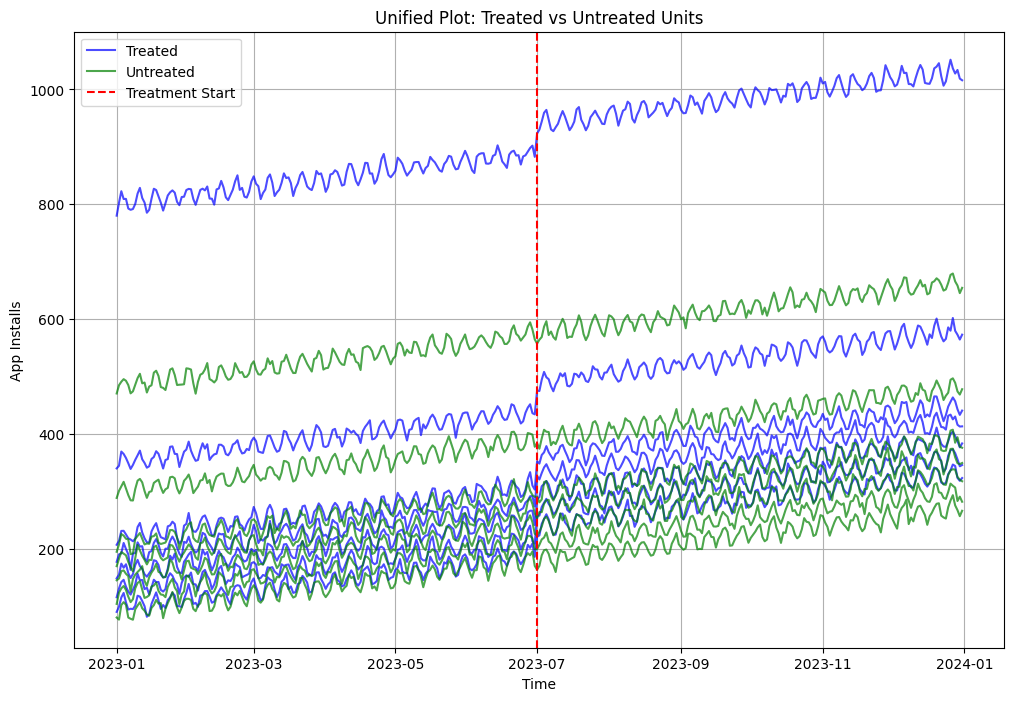

In [15]:
# Redefine all variables and rerun from the beginning to ensure no missing definitions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
days = 365  # one year of data
trend = 0.5  # upward trend
weekly_seasonality_amplitude = 15  # small weekly pattern
noise_std = 5  # idiosyncratic noise
advertisement_effect = 50  # treatment effect
treatment_date = pd.Timestamp("2023-07-01")

# Generate date range
dates = pd.date_range(start="2023-01-01", periods=days)

# Generate weekly seasonality
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

# Create variation in the base effect for units
treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]

# Generate time series for treated units
treated_series = []
for base in treated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    # Apply treatment effect using a mask
    mask = dates >= treatment_date
    app_installs = np.array(app_installs)  # Convert to NumPy array for proper index-based assignment
    app_installs[mask] += advertisement_effect
    treated_series.append(app_installs)

# Generate time series for untreated units
untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

# Combine data into reshaped format
reshaped_data = []
unit_index = 1

for treated, series_group in [(1, treated_series), (0, untreated_series)]:
    for series in series_group:
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "i": unit_index,
                "t": date,
                "Y_it": y_it,
                "post_t": post_t,
                "treated_i": treated,
                "D_it": d_it
            })
        unit_index += 1

# Create DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Display reshaped DataFrame
display(reshaped_df)

# Function to plot unified time series with color differentiation
def plot_unified_time_series(data, treatment_date, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["treated_i"] == treated]
        for unit in subset["i"].unique():
            unit_data = subset[subset["i"] == unit]
            plt.plot(unit_data["t"], unit_data["Y_it"], color=color, alpha=0.7, label=label if unit == subset["i"].min() else "")
    plt.axvline(x=treatment_date, color="red", linestyle="--", label="Treatment Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("App Installs")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the unified time series
plot_unified_time_series(reshaped_df, treatment_date, title="Unified Plot: Treated vs Untreated Units")

In [16]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS, compare

# Prepare the dataset for TWFE analysis
reshaped_df = reshaped_df.set_index(['i', 't'])  # Setting entity (i) and time (t) as the index

# Define dependent and explanatory variables
dependent_var = 'Y_it'
exog_vars = ['D_it']  # Treatment indicator variable

# (1) Fixed Effects, Without Clustering
mod_fixed = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, drop_absorbed=True)
results_fixed_no_cluster = mod_fixed.fit()

# (2) Fixed + Time Effects, Without Clustering
mod_fixed_time = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True)
results_fixed_time_no_cluster = mod_fixed_time.fit()

# (3) Fixed Effects, With Clustering
results_fixed_cluster = mod_fixed.fit(cov_type="clustered", cluster_entity=True)

# (4) Fixed + Time Effects, With Clustering
results_fixed_time_cluster = mod_fixed_time.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

# Compare results
results_table = compare({
    "FE": results_fixed_no_cluster,
    "FE (Clustered)": results_fixed_cluster,
    "TWFE": results_fixed_time_no_cluster,
    "TWFE (Clustered)": results_fixed_time_cluster
})

# Display the comparison table
print(results_table)


                                   Model Comparison                                  
                                    FE FE (Clustered)           TWFE TWFE (Clustered)
-------------------------------------------------------------------------------------
Dep. Variable                     Y_it           Y_it           Y_it             Y_it
Estimator                     PanelOLS       PanelOLS       PanelOLS         PanelOLS
No. Observations                  5110           5110           5110             5110
Cov. Est.                   Unadjusted      Clustered     Unadjusted        Clustered
R-squared                       0.5709         0.5709         0.8723           0.8723
R-Squared (Within)              0.5709         0.5709         0.3334           0.3334
R-Squared (Between)             0.1604         0.1604         0.0606           0.0606
R-Squared (Overall)             0.1713         0.1713         0.0678           0.0678
F-statistic                     6777.7         6777.7 

### Sampling Distribution and Clustered Standard Errors

### Staggered

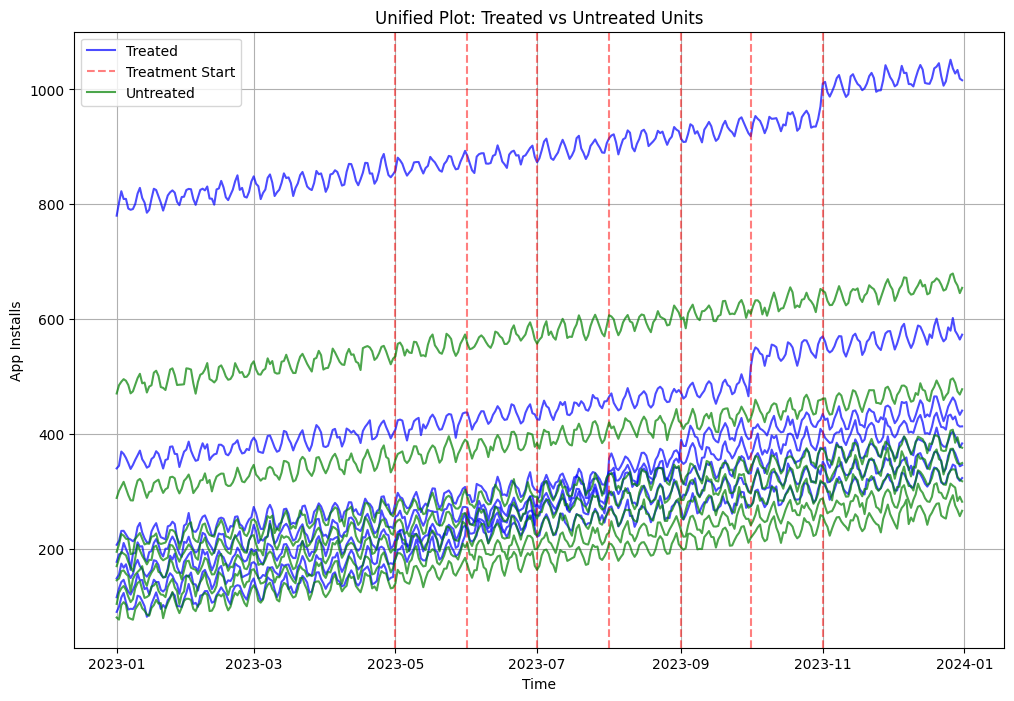

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
days = 365  # one year of data
trend = 0.5  # upward trend
weekly_seasonality_amplitude = 15  # small weekly pattern
noise_std = 5  # idiosyncratic noise
dates = pd.date_range(start="2023-01-01", periods=days)

# Generate weekly seasonality
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

# Create variation in the base effect for units
treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]

# Define staggered treatment dates for treated units
staggered_treatment_dates = [
    pd.Timestamp("2023-05-01"), pd.Timestamp("2023-06-01"),
    pd.Timestamp("2023-07-01"), pd.Timestamp("2023-08-01"),
    pd.Timestamp("2023-09-01"), pd.Timestamp("2023-10-01"),
    pd.Timestamp("2023-11-01")
]

# Generate time series for treated units with staggered adoption
treated_series = []
treated_adoption_dates = []
for base, treatment_date in zip(treated_bases, staggered_treatment_dates):
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    # Apply treatment effect using a mask
    mask = dates >= treatment_date
    app_installs = np.array(app_installs)
    app_installs[mask] += 50  # Treatment effect
    treated_series.append(app_installs)
    treated_adoption_dates.append(treatment_date)

# Generate time series for untreated units
untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

# Combine data into reshaped format
reshaped_data = []
unit_index = 1

for treated, series_group, adoption_dates in [
    (1, treated_series, treated_adoption_dates),
    (0, untreated_series, [None] * len(untreated_series))
]:
    for idx, series in enumerate(series_group):
        treatment_date = adoption_dates[idx] if treated else None
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if treatment_date and date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "i": unit_index,
                "t": date,
                "Y_it": y_it,
                "post_t": post_t,
                "treated_i": treated,
                "D_it": d_it
            })
        unit_index += 1

# Create DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Function to plot unified time series with color differentiation
def plot_unified_time_series(data, staggered_dates, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["treated_i"] == treated]
        for unit in subset["i"].unique():
            unit_data = subset[subset["i"] == unit]
            plt.plot(unit_data["t"], unit_data["Y_it"], color=color, alpha=0.7, label=label if unit == subset["i"].min() else "")
        if treated:
            for date in staggered_dates:
                plt.axvline(x=date, color="red", linestyle="--", alpha=0.5, label="Treatment Start" if date == staggered_dates[0] else "")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("App Installs")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the unified time series
plot_unified_time_series(reshaped_df, staggered_treatment_dates, title="Unified Plot: Treated vs Untreated Units")


In [24]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS, compare

# Prepare the dataset for TWFE analysis
reshaped_df = reshaped_df.set_index(['i', 't'])  # Setting entity (i) and time (t) as the index

# Define dependent and explanatory variables
dependent_var = 'Y_it'
exog_vars = ['D_it']  # Treatment indicator variable

# (1) Fixed Effects, Without Clustering
mod_fixed = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, drop_absorbed=True)
results_fixed_no_cluster = mod_fixed.fit()

# (2) Fixed + Time Effects, Without Clustering
mod_fixed_time = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True)
results_fixed_time_no_cluster = mod_fixed_time.fit()

# (3) Fixed Effects, With Clustering
results_fixed_cluster = mod_fixed.fit(cov_type="clustered", cluster_entity=True)

# (4) Fixed + Time Effects, With Clustering
results_fixed_time_cluster = mod_fixed_time.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

# Compare results
results_table = compare({
    "FE": results_fixed_no_cluster,
    "FE (Clustered)": results_fixed_cluster,
    "TWFE": results_fixed_time_no_cluster,
    "TWFE (Clustered)": results_fixed_time_cluster
})

# Display the comparison table
print(results_table)


                                   Model Comparison                                  
                                    FE FE (Clustered)           TWFE TWFE (Clustered)
-------------------------------------------------------------------------------------
Dep. Variable                     Y_it           Y_it           Y_it             Y_it
Estimator                     PanelOLS       PanelOLS       PanelOLS         PanelOLS
No. Observations                  5110           5110           5110             5110
Cov. Est.                   Unadjusted      Clustered     Unadjusted        Clustered
R-squared                       0.5158         0.5158         0.8848           0.8848
R-Squared (Within)              0.5158         0.5158         0.3003           0.3003
R-Squared (Between)             0.1081         0.1081         0.0412           0.0412
R-Squared (Overall)             0.1187         0.1187         0.0479           0.0479
F-statistic                     5427.6         5427.6 

### Heterogeneity

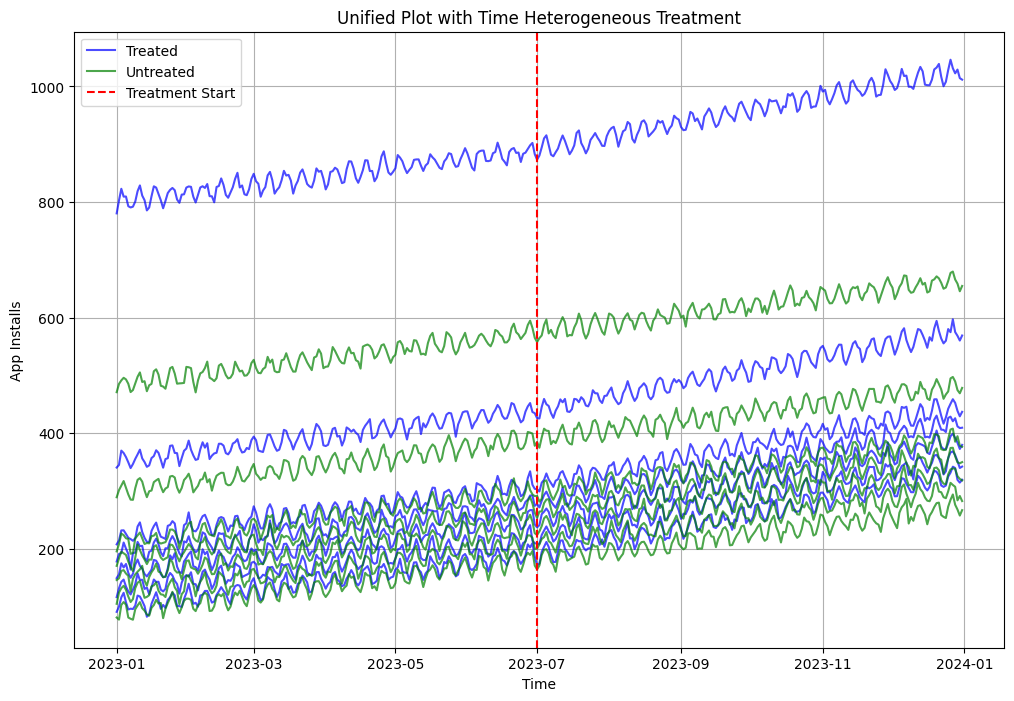

In [16]:
# Adjust the DGP to introduce time heterogeneity in the treatment effect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
days = 365  # one year of data
trend = 0.5  # upward trend
weekly_seasonality_amplitude = 15  # small weekly pattern
noise_std = 5  # idiosyncratic noise
advertisement_effect = 50  # full treatment effect
effect_ramp_days = 200  # time to fully adopt treatment effect
dates = pd.date_range(start="2023-01-01", periods=days)

# Generate weekly seasonality
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

# Create variation in the base effect for units
treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]

# Define treatment date (common for all treated units)
treatment_date = pd.Timestamp("2023-07-01")

# Correcting the issue by converting `app_installs` to a mutable NumPy array for direct modification

# Generate time series for treated units with corrected mutable array
treated_series = []
for base in treated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    app_installs = np.array(app_installs)  # Convert to NumPy array for mutability

    # Apply treatment effect with time heterogeneity
    for t, date in enumerate(dates):
        if date >= treatment_date:
            days_since_treatment = (date - treatment_date).days
            ramp_effect = min(advertisement_effect * (days_since_treatment / effect_ramp_days), advertisement_effect)
            app_installs[t] += ramp_effect

    treated_series.append(app_installs)

# Generate time series for untreated units (no changes needed)
untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

# Combine data into reshaped format
reshaped_data = []
unit_index = 1

for treated, series_group in [(1, treated_series), (0, untreated_series)]:
    for series in series_group:
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "i": unit_index,
                "t": date,
                "Y_it": y_it,
                "post_t": post_t,
                "treated_i": treated,
                "D_it": d_it
            })
        unit_index += 1

# Create DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Function to plot unified time series with color differentiation
def plot_unified_time_series(data, treatment_date, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["treated_i"] == treated]
        for unit in subset["i"].unique():
            unit_data = subset[subset["i"] == unit]
            plt.plot(unit_data["t"], unit_data["Y_it"], color=color, alpha=0.7, label=label if unit == subset["i"].min() else "")
    plt.axvline(x=treatment_date, color="red", linestyle="--", label="Treatment Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("App Installs")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the unified time series
plot_unified_time_series(reshaped_df, treatment_date, title="Unified Plot with Time Heterogeneous Treatment")

In [14]:
from linearmodels.panel import PanelOLS, compare

# Prepare the dataset for TWFE analysis
reshaped_df = reshaped_df.set_index(['i', 't'])  # Setting entity (i) and time (t) as the index

# Define dependent and explanatory variables
dependent_var = 'Y_it'
exog_vars = ['D_it']  # Treatment indicator variable

# (1) Fixed Effects, Without Clustering
mod_fixed = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, drop_absorbed=True)
results_fixed_no_cluster = mod_fixed.fit()

# (2) Fixed + Time Effects, Without Clustering
mod_fixed_time = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True)
results_fixed_time_no_cluster = mod_fixed_time.fit()

# (3) Fixed Effects, With Clustering
results_fixed_cluster = mod_fixed.fit(cov_type="clustered", cluster_entity=True)

# (4) Fixed + Time Effects, With Clustering
results_fixed_time_cluster = mod_fixed_time.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

# Compare results
results_table = compare({
    "FE": results_fixed_no_cluster,
    "FE (Clustered)": results_fixed_cluster,
    "TWFE": results_fixed_time_no_cluster,
    "TWFE (Clustered)": results_fixed_time_cluster
})

# Display the comparison table
print(results_table)

                                   Model Comparison                                  
                                    FE FE (Clustered)           TWFE TWFE (Clustered)
-------------------------------------------------------------------------------------
Dep. Variable                     Y_it           Y_it           Y_it             Y_it
Estimator                     PanelOLS       PanelOLS       PanelOLS         PanelOLS
No. Observations                  5110           5110           5110             5110
Cov. Est.                   Unadjusted      Clustered     Unadjusted        Clustered
R-squared                       0.4368         0.4368         0.4240           0.4240
R-Squared (Within)              0.4368         0.4368         0.1582           0.1582
R-Squared (Between)             0.1314         0.1314         0.0282           0.0282
R-Squared (Overall)             0.1386         0.1386         0.0313           0.0313
F-statistic                     3951.6         3951.6 

Estimating dynamic specification...


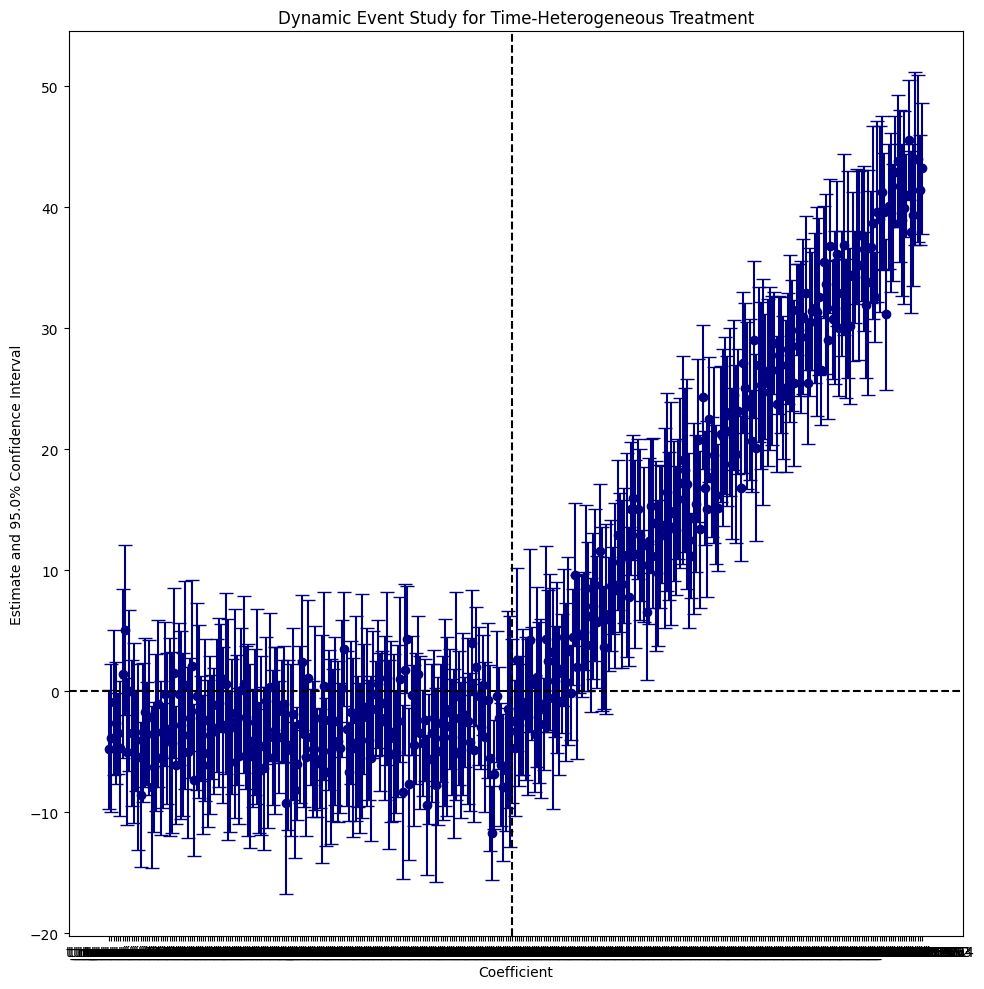

In [17]:
import pyfixest as pf
from pyfixest.report.utils import rename_event_study_coefs

# Convert date column to numeric indices for event study
reshaped_df['t_numeric'] = (reshaped_df['t'] - reshaped_df['t'].min()).dt.days

# Estimate the dynamic model
print("Estimating dynamic specification...")
fit_dynamic_twfe = pf.feols(
    "Y_it ~ i(t_numeric, treated_i, ref=180) | i + t_numeric",  # Dynamic model
    reshaped_df,
    vcov={"CRV1": "i"},  # Clustered by unit
)

# Plot the event study results
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Dynamic Event Study for Time-Heterogeneous Treatment",
    figsize=[10, 10],
    yintercept=0,
    xintercept=180,  # Reference period
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
    plot_backend="matplotlib",
)


### Staggered + Heterogeneity

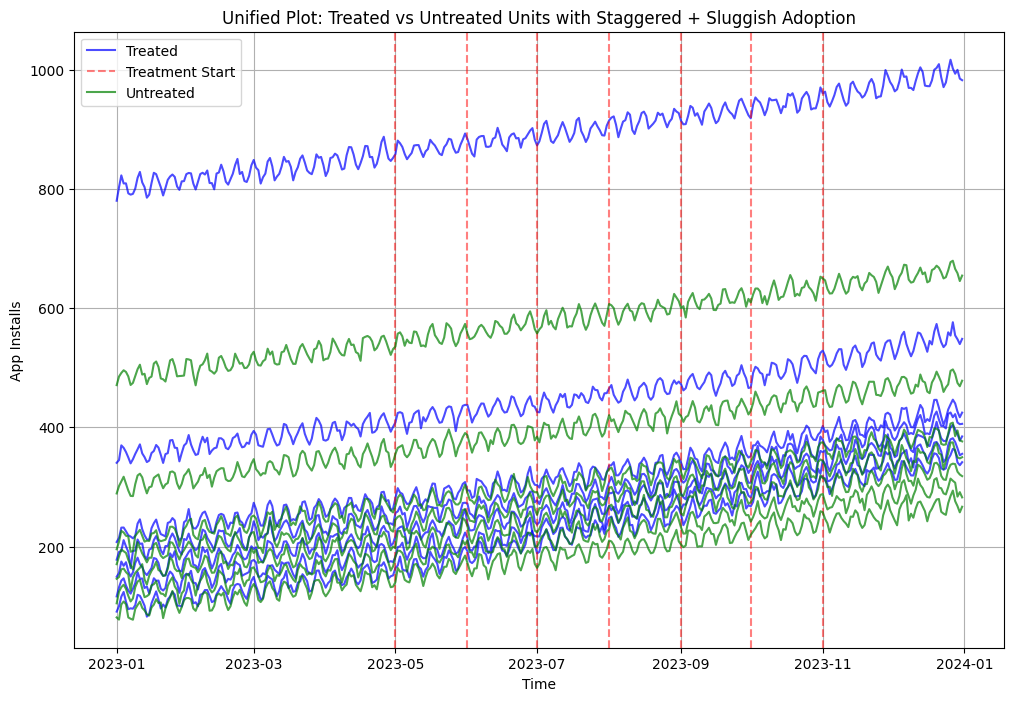

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
days = 365  # one year of data
trend = 0.5  # upward trend
weekly_seasonality_amplitude = 15  # small weekly pattern
noise_std = 5  # idiosyncratic noise
advertisement_effect = 100  # full treatment effect
effect_ramp_days = 360  # time to fully adopt treatment effect
dates = pd.date_range(start="2023-01-01", periods=days)

# Generate weekly seasonality
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

# Create variation in the base effect for units
treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]

# Define staggered treatment dates for treated units
staggered_treatment_dates = [
    pd.Timestamp("2023-05-01"), pd.Timestamp("2023-06-01"),
    pd.Timestamp("2023-07-01"), pd.Timestamp("2023-08-01"),
    pd.Timestamp("2023-09-01"), pd.Timestamp("2023-10-01"),
    pd.Timestamp("2023-11-01")
]

# Generate time series for treated units with staggered and sluggish adoption
treated_series = []
treated_adoption_dates = []
for base, treatment_date in zip(treated_bases, staggered_treatment_dates):
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    app_installs = np.array(app_installs)

    # Apply sluggish adoption effect
    for t, date in enumerate(dates):
        if date >= treatment_date:
            days_since_treatment = (date - treatment_date).days
            ramp_effect = min(advertisement_effect * (days_since_treatment / effect_ramp_days), advertisement_effect)
            app_installs[t] += ramp_effect

    treated_series.append(app_installs)
    treated_adoption_dates.append(treatment_date)

# Generate time series for untreated units
untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

# Combine data into reshaped format
reshaped_data = []
unit_index = 1

for treated, series_group, adoption_dates in [
    (1, treated_series, treated_adoption_dates),
    (0, untreated_series, [None] * len(untreated_series))
]:
    for idx, series in enumerate(series_group):
        treatment_date = adoption_dates[idx] if treated else None
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if treatment_date and date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "i": unit_index,
                "t": date,
                "Y_it": y_it,
                "post_t": post_t,
                "treated_i": treated,
                "D_it": d_it
            })
        unit_index += 1

# Create DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Function to plot unified time series with staggered and sluggish adoption
def plot_unified_time_series(data, staggered_dates, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["treated_i"] == treated]
        for unit in subset["i"].unique():
            unit_data = subset[subset["i"] == unit]
            plt.plot(unit_data["t"], unit_data["Y_it"], color=color, alpha=0.7, label=label if unit == subset["i"].min() else "")
        if treated:
            for date in staggered_dates:
                plt.axvline(x=date, color="red", linestyle="--", alpha=0.5, label="Treatment Start" if date == staggered_dates[0] else "")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("App Installs")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the unified time series
plot_unified_time_series(reshaped_df, staggered_treatment_dates, title="Unified Plot: Treated vs Untreated Units with Staggered + Sluggish Adoption")

In [27]:
from linearmodels.panel import PanelOLS, compare

# Prepare the dataset for TWFE analysis
reshaped_df = reshaped_df.set_index(['i', 't'])  # Setting entity (i) and time (t) as the index

# Define dependent and explanatory variables
dependent_var = 'Y_it'
exog_vars = ['D_it']  # Treatment indicator variable

# (1) Fixed Effects, Without Clustering
mod_fixed = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, drop_absorbed=True)
results_fixed_no_cluster = mod_fixed.fit()

# (2) Fixed + Time Effects, Without Clustering
mod_fixed_time = PanelOLS(reshaped_df[dependent_var], reshaped_df[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True)
results_fixed_time_no_cluster = mod_fixed_time.fit()

# (3) Fixed Effects, With Clustering
results_fixed_cluster = mod_fixed.fit(cov_type="clustered", cluster_entity=True)

# (4) Fixed + Time Effects, With Clustering
results_fixed_time_cluster = mod_fixed_time.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

# Compare results
results_table = compare({
    "FE": results_fixed_no_cluster,
    "FE (Clustered)": results_fixed_cluster,
    "TWFE": results_fixed_time_no_cluster,
    "TWFE (Clustered)": results_fixed_time_cluster
})

# Display the comparison table
print(results_table)

                                   Model Comparison                                  
                                    FE FE (Clustered)           TWFE TWFE (Clustered)
-------------------------------------------------------------------------------------
Dep. Variable                     Y_it           Y_it           Y_it             Y_it
Estimator                     PanelOLS       PanelOLS       PanelOLS         PanelOLS
No. Observations                  5110           5110           5110             5110
Cov. Est.                   Unadjusted      Clustered     Unadjusted        Clustered
R-squared                       0.3821         0.3821         0.2435           0.2435
R-Squared (Within)              0.3821         0.3821         0.1092           0.1092
R-Squared (Between)             0.0875         0.0875         0.0147           0.0147
R-Squared (Overall)             0.0944         0.0944         0.0169           0.0169
F-statistic                     3151.0         3151.0 

Estimating dynamic specification...


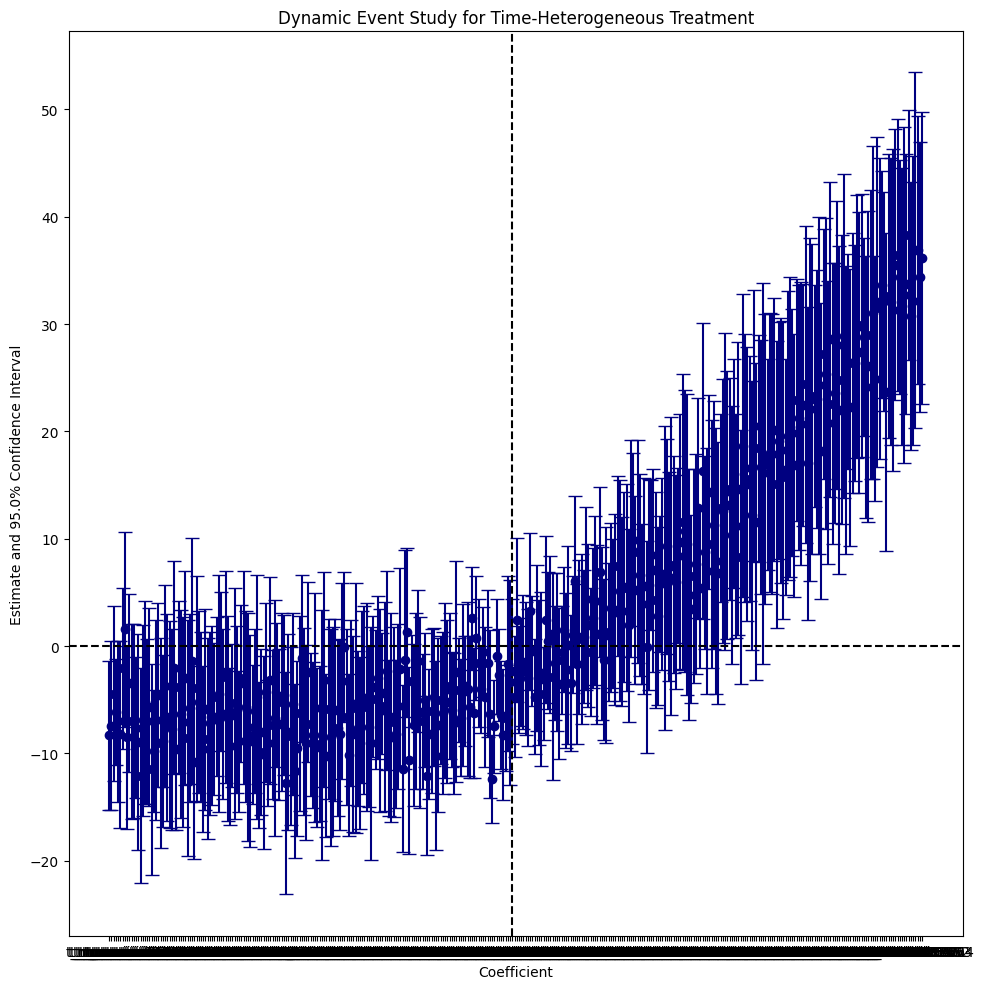

In [29]:
import pyfixest as pf
from pyfixest.report.utils import rename_event_study_coefs

# Convert date column to numeric indices for event study
reshaped_df['t_numeric'] = (reshaped_df['t'] - reshaped_df['t'].min()).dt.days

# Estimate the dynamic model
print("Estimating dynamic specification...")
fit_dynamic_twfe = pf.feols(
    "Y_it ~ i(t_numeric, treated_i, ref=180) | i + t_numeric",  # Dynamic model
    reshaped_df,
    vcov={"CRV1": "i"},  # Clustered by unit
)

# Plot the event study results
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Dynamic Event Study for Time-Heterogeneous Treatment",
    figsize=[10, 10],
    yintercept=0,
    xintercept=180,  # Reference period
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
    plot_backend="matplotlib",
)

### Santana Calloway

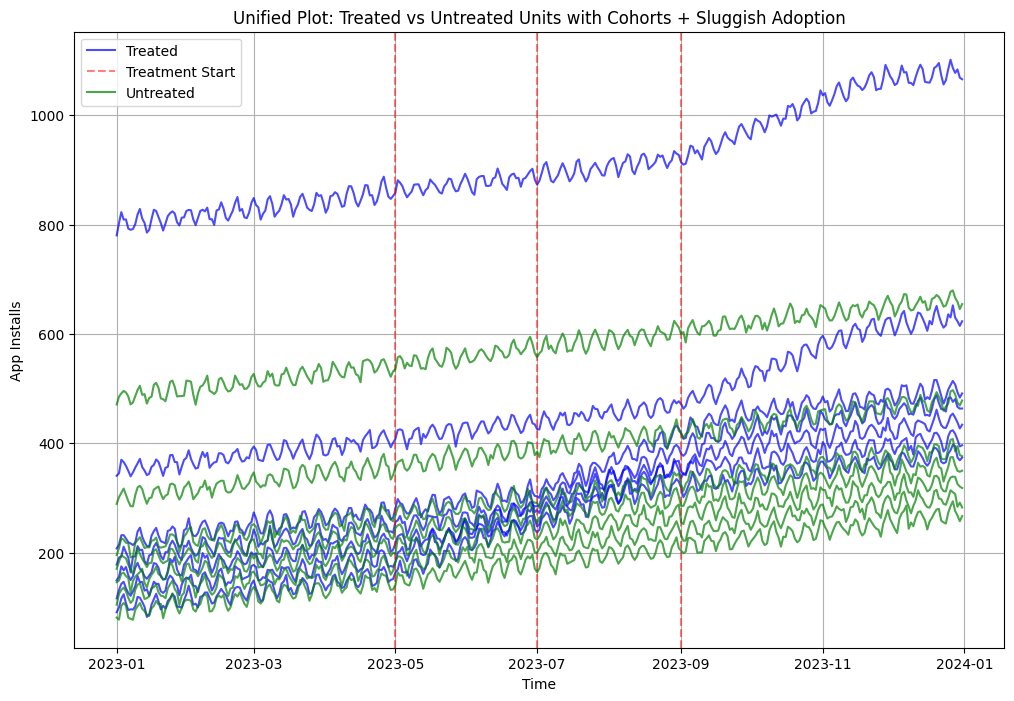

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
days = 365  # one year of data
trend = 0.5  # upward trend
weekly_seasonality_amplitude = 15  # small weekly pattern
noise_std = 5  # idiosyncratic noise
advertisement_effect = 100  # full treatment effect
effect_ramp_days = 80  # time to fully adopt treatment effect
dates = pd.date_range(start="2023-01-01", periods=days)

# Generate weekly seasonality
weekly_pattern = (weekly_seasonality_amplitude *
                  np.sin(2 * np.pi * (dates.dayofweek / 7.0)))

# Create variation in the base effect for units
treated_bases = [100, 130, 160, 190, 220, 350, 800]
untreated_bases = [90, 120, 150, 180, 210, 300, 484]

# Define cohorts (groups of units) treated on the same date
cohort_treatment_dates = {
    pd.Timestamp("2023-05-01"): [100, 130],  # Cohort 1: Units 1 & 2
    pd.Timestamp("2023-07-01"): [160, 190, 220],  # Cohort 2: Units 3, 4 & 5
    pd.Timestamp("2023-09-01"): [350, 800],  # Cohort 3: Units 6 & 7
}

# Generate time series for treated units (grouped by cohorts)
treated_series = []
treated_adoption_dates = []
for treatment_date, bases in cohort_treatment_dates.items():
    for base in bases:
        trend_values = np.arange(base, base + trend * days, trend)
        app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
        app_installs = np.maximum(0, app_installs)
        app_installs = np.array(app_installs)

        # Apply sluggish adoption effect
        for t, date in enumerate(dates):
            if date >= treatment_date:
                days_since_treatment = (date - treatment_date).days
                ramp_effect = min(advertisement_effect * (days_since_treatment / effect_ramp_days), advertisement_effect)
                app_installs[t] += ramp_effect

        treated_series.append(app_installs)
        treated_adoption_dates.append(treatment_date)

# Generate time series for untreated units
untreated_series = []
for base in untreated_bases:
    trend_values = np.arange(base, base + trend * days, trend)
    app_installs = trend_values + weekly_pattern + np.random.normal(0, noise_std, size=days)
    app_installs = np.maximum(0, app_installs)
    untreated_series.append(app_installs)

# Combine data into reshaped format
reshaped_data = []
unit_index = 1

for treated, series_group, adoption_dates in [
    (1, treated_series, treated_adoption_dates),
    (0, untreated_series, [None] * len(untreated_series))
]:
    for idx, series in enumerate(series_group):
        treatment_date = adoption_dates[idx] if treated else None
        for t, (date, y_it) in enumerate(zip(dates, series)):
            post_t = 1 if treatment_date and date >= treatment_date else 0
            d_it = post_t * treated
            reshaped_data.append({
                "i": unit_index,
                "t": date,
                "Y_it": y_it,
                "post_t": post_t,
                "treated_i": treated,
                "D_it": d_it
            })
        unit_index += 1

# Create DataFrame
reshaped_df = pd.DataFrame(reshaped_data)

# Function to plot unified time series with grouped adoption
def plot_unified_time_series(data, treatment_dates, title="Unified Time Series Plot"):
    plt.figure(figsize=(12, 8))
    for treated, color, label in [(1, "blue", "Treated"), (0, "green", "Untreated")]:
        subset = data[data["treated_i"] == treated]
        for unit in subset["i"].unique():
            unit_data = subset[subset["i"] == unit]
            plt.plot(unit_data["t"], unit_data["Y_it"], color=color, alpha=0.7, label=label if unit == subset["i"].min() else "")
        if treated:
            for date in treatment_dates:
                plt.axvline(x=date, color="red", linestyle="--", alpha=0.5, label="Treatment Start" if date == list(treatment_dates.keys())[0] else "")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("App Installs")
    plt.legend()
    plt.grid()
    plt.show()

# Plot the unified time series
plot_unified_time_series(reshaped_df, cohort_treatment_dates, title="Unified Plot: Treated vs Untreated Units with Cohorts + Sluggish Adoption")


In [38]:
import pandas as pd
import pyfixest as pf
import matplotlib.pyplot as plt

# Assuming `reshaped_df` is already defined

# Prepare data for TWFE and LPDID
reshaped_df["t"] = reshaped_df["t"].astype("datetime64[ns]")
reshaped_df["t_numeric"] = reshaped_df["t"].dt.strftime('%Y%m%d').astype(int)  # Convert time to numeric format
reshaped_df["i"] = reshaped_df["i"].astype("category")
reshaped_df["rel_year"] = reshaped_df["t"].dt.year - reshaped_df.groupby("i")["t"].transform("min").dt.year

# TWFE: Estimate event study
print("Estimating TWFE model...")
fit_twfe = pf.feols(
    "Y_it ~ i(rel_year, ref=0) | i + t",
    reshaped_df,
    vcov={"CRV1": "i"},
)

# LPDID: Estimate event study
print("Estimating Local Projections model...")
fit_lpdid = pf.lpdid(
    data=reshaped_df,
    yname="Y_it",
    gname="D_it",
    tname="t_numeric",  # Use numeric time column
    idname="i",
    vcov={"CRV1": "i"},
    pre_window=-20,
    post_window=20,
    att=False,
)

# TWFE: Extract coefficients for plotting
print("Preparing TWFE results for plotting...")
twfe_results = fit_twfe.tidy()
twfe_results = twfe_results[
    twfe_results.index.str.contains("rel_year", regex=True)
]

# Plot TWFE Event Study
plt.figure(figsize=(12, 6))
plt.errorbar(
    twfe_results.index,
    twfe_results["Estimate"],
    yerr=[
        twfe_results["Estimate"] - twfe_results["2.5%"],
        twfe_results["97.5%"] - twfe_results["Estimate"],
    ],
    fmt="o",
    capsize=5,
    label="TWFE",
)
plt.axhline(0, color="red", linestyle="--", label="Zero Line")
plt.xticks(rotation=45, ha="right")
plt.title("TWFE Event Study")
plt.xlabel("Relative Year")
plt.ylabel("Coefficient")
plt.legend()
plt.show()

# LPDID: Extract coefficients for plotting
print("Preparing LPDID results for plotting...")
lpdid_results = fit_lpdid.tidy()
lpdid_results = lpdid_results[
    lpdid_results.index.str.contains("time_to_treatment", regex=True)
]

# Plot LPDID Event Study
plt.figure(figsize=(12, 6))
plt.errorbar(
    lpdid_results.index,
    lpdid_results["Estimate"],
    yerr=[
        lpdid_results["Estimate"] - lpdid_results["2.5%"],
        lpdid_results["97.5%"] - lpdid_results["Estimate"],
    ],
    fmt="o",
    capsize=5,
    label="LPDID",
)
plt.axhline(0, color="red", linestyle="--", label="Zero Line")
plt.xticks(rotation=45, ha="right")
plt.title("LPDID Event Study")
plt.xlabel("Relative Year")
plt.ylabel("Coefficient")
plt.legend()
plt.show()


/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_31835/2338662731.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reshaped_df["rel_year"] = reshaped_df["t"].dt.year - reshaped_df.groupby("i")["t"].transform("min").dt.year


Estimating TWFE model...
Estimating Local Projections model...


/Users/pranjal/myenv/lib/python3.11/site-packages/pyfixest/did/lpdid.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[f"{yname}_lag"] = data.groupby(idname)[yname].shift(1)
/Users/pranjal/myenv/lib/python3.11/site-packages/pyfixest/did/lpdid.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data["treat_diff"] = data["treat"] - data.groupby(idname)["treat"].shift(1)


ValueError: pre_window must be in [20230500. 20230501. 20230502. 20230503. 20230504. 20230505. 20230506.
 20230507. 20230508. 20230509. 20230510. 20230511. 20230512. 20230513.
 20230514. 20230515. 20230516. 20230517. 20230518. 20230519. 20230520.
 20230521. 20230522. 20230523. 20230524. 20230525. 20230526. 20230527.
 20230528. 20230529. 20230530. 20230600. 20230601. 20230602. 20230603.
 20230604. 20230605. 20230606. 20230607. 20230608. 20230609. 20230610.
 20230611. 20230612. 20230613. 20230614. 20230615. 20230616. 20230617.
 20230618. 20230619. 20230620. 20230621. 20230622. 20230623. 20230624.
 20230625. 20230626. 20230627. 20230628. 20230629. 20230700. 20230701.
 20230702. 20230703. 20230704. 20230705. 20230706. 20230707. 20230708.
 20230709. 20230710. 20230711. 20230712. 20230713. 20230714. 20230715.
 20230716. 20230717. 20230718. 20230719. 20230720. 20230721. 20230722.
 20230723. 20230724. 20230725. 20230726. 20230727. 20230728. 20230729.
 20230730. 20230800. 20230801. 20230802. 20230803. 20230804. 20230805.
 20230806. 20230807. 20230808. 20230809. 20230810. 20230811. 20230812.
 20230813. 20230814. 20230815. 20230816. 20230817. 20230818. 20230819.
 20230820. 20230821. 20230822. 20230823. 20230824. 20230825. 20230826.
 20230827. 20230828. 20230829. 20230830. 20230900. 20230901. 20230902.
 20230903. 20230904. 20230905. 20230906. 20230907. 20230908. 20230909.
 20230910. 20230911. 20230912. 20230913. 20230914. 20230915. 20230916.
 20230917. 20230918. 20230919. 20230920. 20230921. 20230922. 20230923.
 20230924. 20230925. 20230926. 20230927. 20230928. 20230929. 20231000.
 20231001. 20231002. 20231003. 20231004. 20231005. 20231006. 20231007.
 20231008. 20231009. 20231010. 20231011. 20231012. 20231013. 20231014.
 20231015. 20231016. 20231017. 20231018. 20231019. 20231020. 20231021.
 20231022. 20231023. 20231024. 20231025. 20231026. 20231027. 20231028.
 20231029. 20231030. 20231100. 20231101. 20231102. 20231103. 20231104.
 20231105. 20231106. 20231107. 20231108. 20231109. 20231110. 20231111.
 20231112. 20231113. 20231114. 20231115. 20231116. 20231117. 20231118.
 20231119. 20231120. 20231121. 20231122. 20231123. 20231124. 20231125.
 20231126. 20231127. 20231128. 20231129. 20231200. 20231201. 20231202.
 20231203. 20231204. 20231205. 20231206. 20231207. 20231208. 20231209.
 20231210. 20231211. 20231212. 20231213. 20231214. 20231215. 20231216.
 20231217. 20231218. 20231219. 20231220. 20231221. 20231222. 20231223.
 20231224. 20231225. 20231226. 20231227. 20231228. 20231229. 20231230.]

Loading multi-cohort adoption data...
Estimating TWFE model...
Estimating Gardner's 2-Step model...
Estimating Local Projections model...
Plotting TWFE results...
Plotting Local Projections results...


KeyError: 'Coefficient'

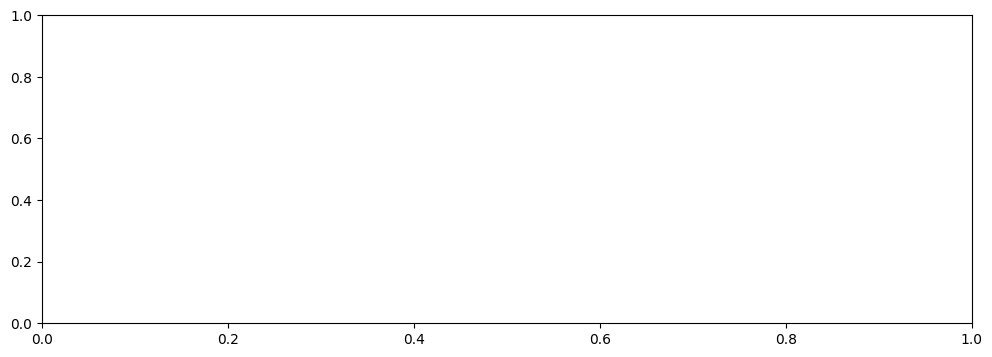

In [32]:
from importlib import resources
import pandas as pd
import pyfixest as pf
from pyfixest.report.utils import rename_event_study_coefs

# Load the multi-cohort adoption data
print("Loading multi-cohort adoption data...")
df_multi_cohort = pd.read_csv(
    resources.files("pyfixest.did.data").joinpath("df_het.csv")
)

# Two-Way Fixed Effects
print("Estimating TWFE model...")
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    df_multi_cohort,
    vcov={"CRV1": "state"},
)

# Gardner's 2-Step Estimator
print("Estimating Gardner's 2-Step model...")
fit_did2s = pf.did2s(
    df_multi_cohort,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year, ref=-1.0)",
    treatment="treat",
    cluster="state",
)

# Local Projections
print("Estimating Local Projections model...")
fit_lpdid = pf.lpdid(
    data=df_multi_cohort,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=False,
)

# Plot results using matplotlib backend
figsize = [12, 4]
print("Plotting TWFE results...")
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
    labels=rename_event_study_coefs(fit_twfe._coefnames),
    plot_backend="matplotlib",  # Specify matplotlib as the backend
)

print("Plotting Local Projections results...")
fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
    plot_backend="matplotlib",  # Specify matplotlib as the backend
)

# Pooled Effects
print("Estimating pooled effects for TWFE, DID2s, and LPDID...")
fit_twfe_pooled = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_multi_cohort,
    vcov={"CRV1": "state"},
)

fit_did2s_pooled = pf.did2s(
    df_multi_cohort,
    yname="dep_var",
    first_stage="~ 0 | unit + year",
    second_stage="~i(treat)",
    treatment="treat",
    cluster="state",
)

fit_lpdid_pooled = pf.lpdid(
    data=df_multi_cohort,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=True,
)

# Combine and display results
print("Combining pooled effects results...")
results = pd.concat(
    [
        fit_twfe_pooled.tidy().assign(estimator="TWFE"),
        fit_did2s_pooled.tidy().assign(estimator="DID2s"),
        fit_lpdid_pooled.tidy().assign(estimator="LPDID").drop("N", axis=1),
    ],
    axis=0,
)

print("Pooled effects results:")
print(results)
